In [1]:
simulation_num <- 2


maxsteps = 100
my.minlam <- 10^(-5)
nfold <- 10
outerCV_folds <- 5
graphComponents <- 2
percent <- 0.8

feature.names <- c("A", "B")

intercept_mode <- TRUE

outPath <- "~/mount2/flassoTool/simulation/sim/"
dir.create(outPath,showWarnings = F)

source('~/mount2/flassoTool/wrapper_functions_RSSmeasureModelSelection_gamma_parallel.R')
source('~/mount2/flassoTool/UtilityFunctions_sequentialCV.R')


In [2]:
feature.names <- c("A", "B")
fileName <- paste("simulation",simulation_num, sep="")

In [3]:
data.x <- as.matrix(read.table(paste("~/mount2/flassoTool/simulation/fl_sim_features_",simulation_num,".txt", sep="")))
data.y <- as.numeric(readLines(paste("~/mount2/flassoTool/simulation/fl_sim_response_",simulation_num,".txt", sep="")))

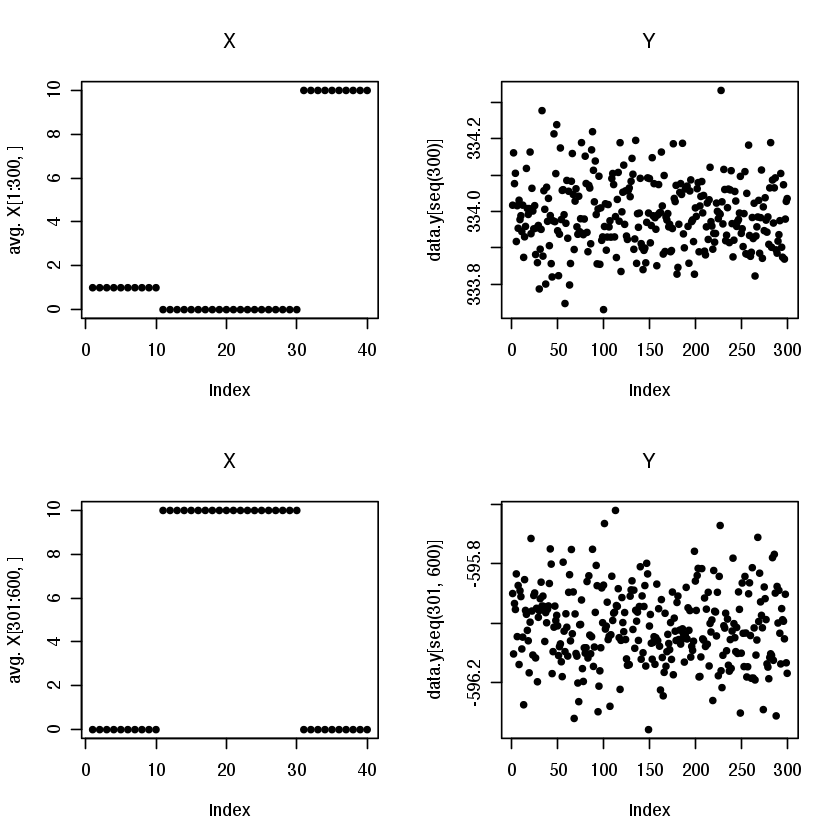

In [4]:
par(mfrow= c(2,2));
plot(colMeans(data.x[seq(300),]), main= "X", ylab= "avg. X[1:300, ]", pch= 20)
plot(data.y[seq(300)], main= "Y", pch= 20)
plot(colMeans(data.x[seq(301, 600),]), main= "X", ylab= "avg. X[301:600, ]", pch= 20)
plot(data.y[seq(301, 600)], main= "Y", pch= 20)


In [5]:
bestGammasIdx <- 1
ctr <- 1

shuffle <- sample(length(data.y))
data.x <- data.x[shuffle,]
data.y <- data.y[shuffle]

In [6]:
bin.cnt <- ncol(data.x)/graphComponents
edgs <- NULL
for(i in 1:graphComponents)
{
    edgs <- c(edgs,bin.cnt*(i-1)+1, rep((bin.cnt*(i-1)+2):(bin.cnt*i - 1),each=2),bin.cnt*i)
}

In [7]:
  partition <- data.partition(data.x,data.y,percent=percent)

In [8]:
train.group.rescaled <- group.rescale(partition$train$x,0,1,bin.cnt)
partition$train$x <- train.group.rescaled$x
partition$test$x <- group.rescale(partition$test$x,0,1,bin.cnt,train.group.rescaled$min,train.group.rescaled$max)$x

In [9]:
outer_CV_partitions <- get.outerCV.partitions(data.x,data.y,n.folds=outerCV_folds)

In [10]:
gammas <- 0
  for(i in seq(-5,5)){
    gammas <- c(gammas,(10^i))
  }

In [11]:
bestgammas <-vector(mode='numeric',length=1)
bestGammasIdx <- 1

In [12]:
#fl.outerCV <- sapply(seq(outerCV_folds),function(i)fusedlasso.main_ForLambdaInterpolation(outer_CV_partitions[[i]]$train$x,outer_CV_partitions[[i]]$train$y,bin.cnt,edgs,gammas,intercept_mode))

In [13]:
  fl <- fusedlasso.main_ForLambdaInterpolation(partition$train$x,partition$train$y,bin.cnt,edgs,gammas,intercept_mode)

Loading required package: doSNOW
Loading required package: foreach
Loading required package: iterators
Loading required package: snow
Loading required package: scatterplot3d
Loading required package: parallel

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster

Loading required package: genlasso
Loading required package: MASS
Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



[1] 120
[1] 30
[1] 12
[1] "0 5.00765295408162e-14"
[1] "1e-05 0.0044913692959266"
[1] "1e-04 5.58590518476669e-14"
[1] "0.001 4.55684356300809e-13"
[1] "0.01 1.13218509469106e-14"
[1] "0.1 5.17000198043102e-12"
[1] "1 9.44646928836679e-14"
[1] "10 1.54742948487835e-05"
[1] "100 4.33514003451223e-05"
[1] "1000 0.0067697952425727"
[1] "10000 0.00726737872297919"
[1] "1e+05 0.00728362156040179"
[1] "search.depth=1"


In [14]:
best.cv.gamma <- fl$gamma.best

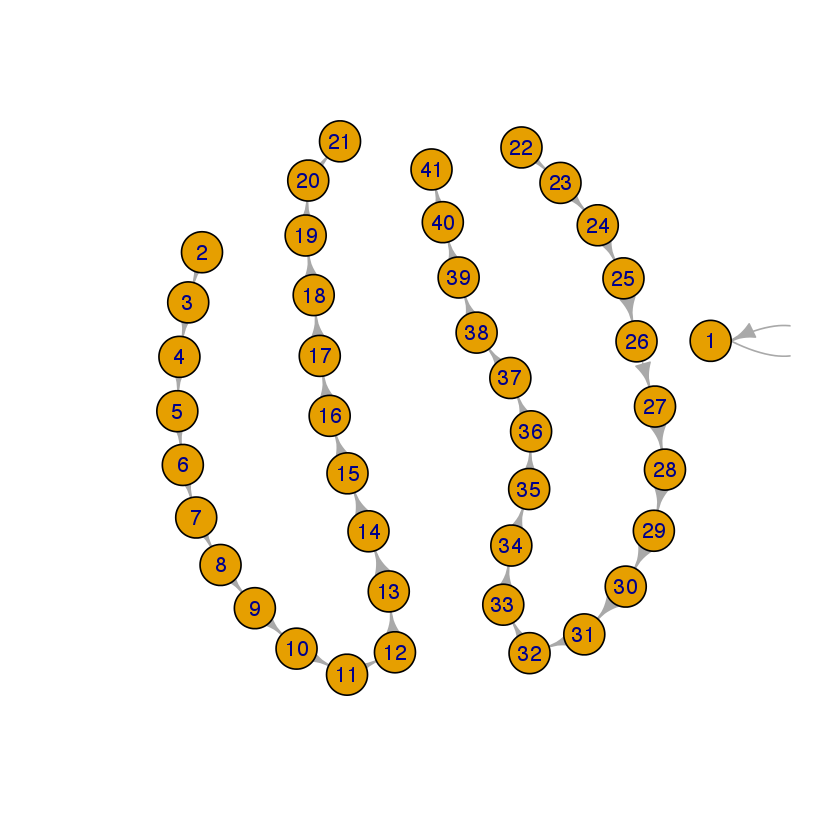

In [15]:
if(intercept_mode){
    edgs <- edgs + 1
    edgs <- c(1,1,edgs)
}
plot(graph(edgs))

if(intercept_mode){
    fl.best <- fusedlasso(X=cbind(1,partition$train$x),y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
}else{
    fl.best <- fusedlasso(X=partition$train$x,y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
}


In [16]:
bestgammas[bestGammasIdx] <- fl$gamma.best

In [17]:
fl.best.min.lambda <- min(fl.best$lambda) 
beta.best <- coef.genlasso(fl.best,max(fl.best.min.lambda,fl$best.lambda))$beta
print('Done running fusedlasso.main')
cv.beta.mat.fl <- fl$cv.fl$cv.beta.mat
print(c('dim(cv.beta.mat.fl)',dim(cv.beta.mat.fl)))
cv.beta.mat.nl <- cv.beta.matrix.nl(partition$train$x,partition$train$y,nfold)

[1] "Done running fusedlasso.main"
[1] "dim(cv.beta.mat.fl)" "10"                  "41"                 


Loading required package: glmnet
Loaded glmnet 2.0-10



[1] "length(nl.beta)" "41"             


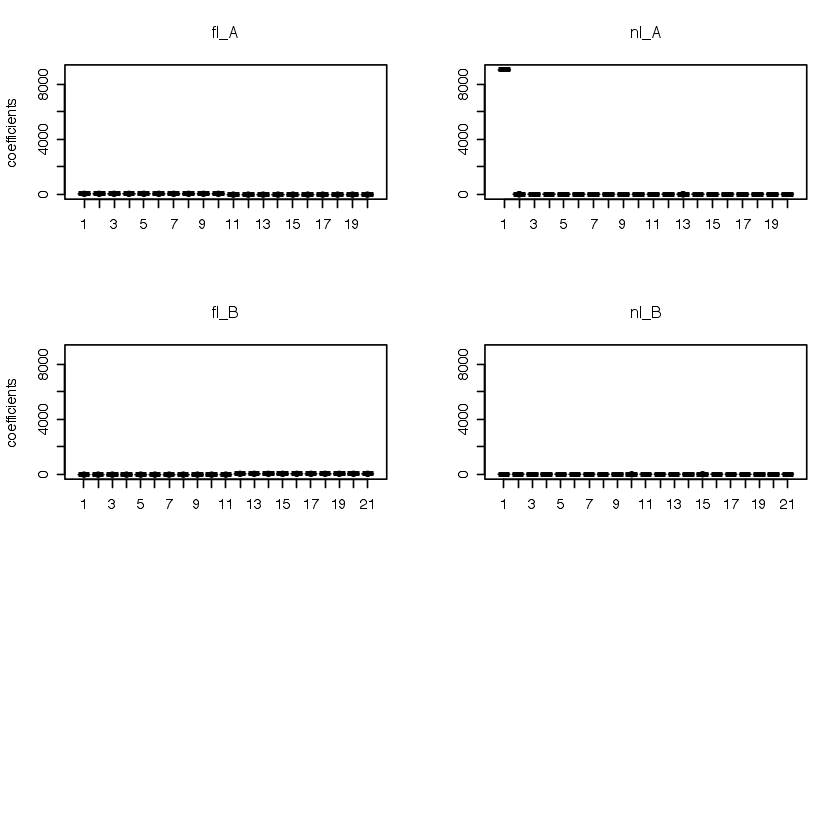

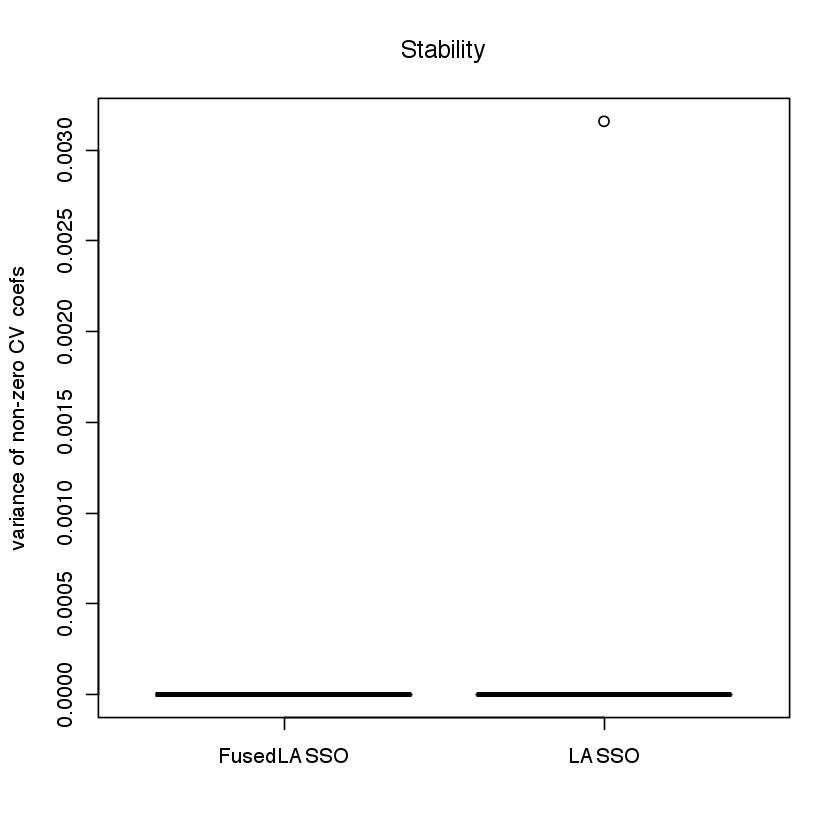

In [18]:
plot.stability(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,bin.cnt,feature.names,intercept_mode)
plot.stability.var(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,intercept_mode)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



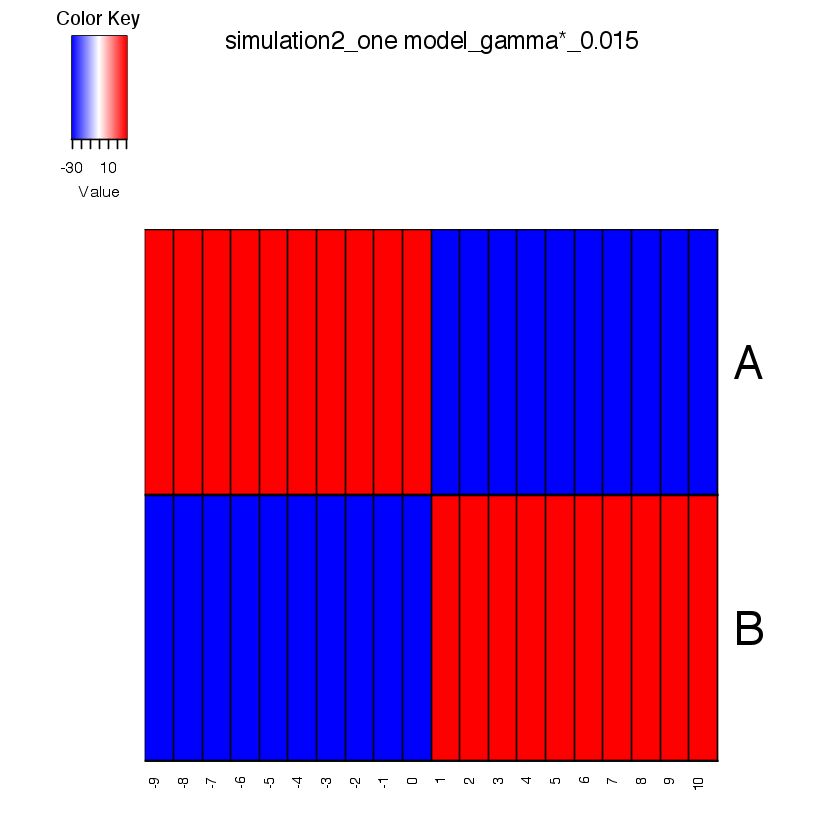

In [19]:
plot.histone.coef(beta.best,bin.cnt,feature.names,main=paste(fileName,'one model','gamma*',bestgammas[bestGammasIdx],sep='_'),intercept_mode)#,cluster_rows = F, cluster_cols = F)

In [20]:
correlations.fl <- matrix(0,ncol=3,nrow=2)#2 rows for spearman and pearson correlation and 3 columns for test, train, and entire dataset
correlations.nl <- matrix(0,ncol=3,nrow=2)

In [21]:
test.y <- partition$test$y
  if(intercept_mode){
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(partition$train$x,partition$test$x)
  }else{
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(train.x,test.x)
  }

$rss
[1] 1.985613e-06

$cor
[1] 1 1

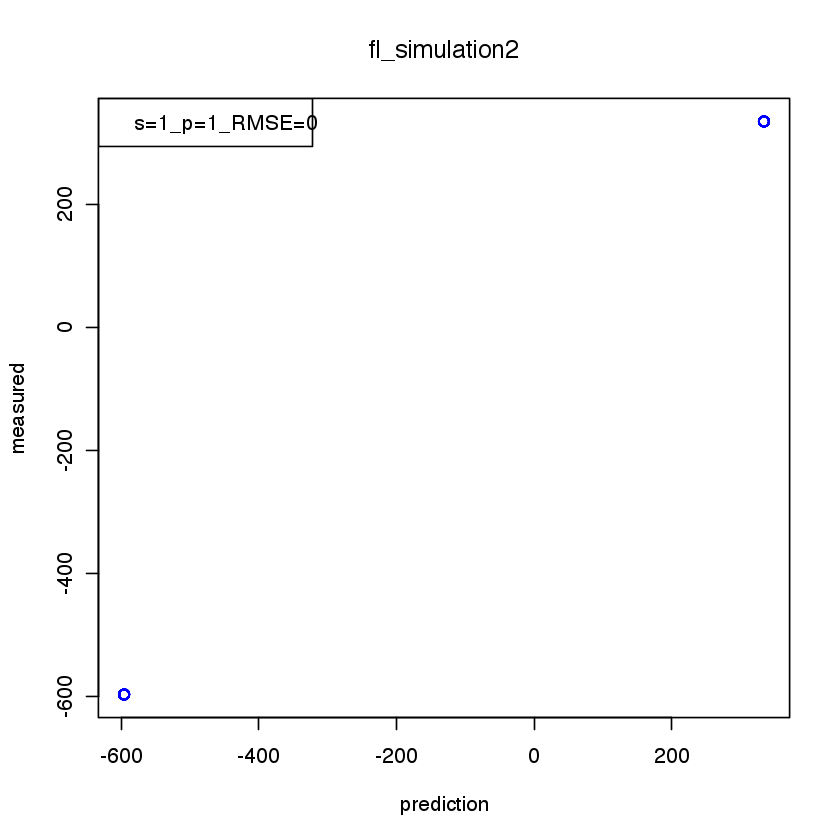

In [22]:
plot.scatter(test.x,test.y,beta.best,0,"measured",main=paste('fl',fileName,sep='_'),is_fl=T,intercept_mode,xlab='prediction')

$rss
[1] 14.89262

$cor
[1] 0.86 1.00

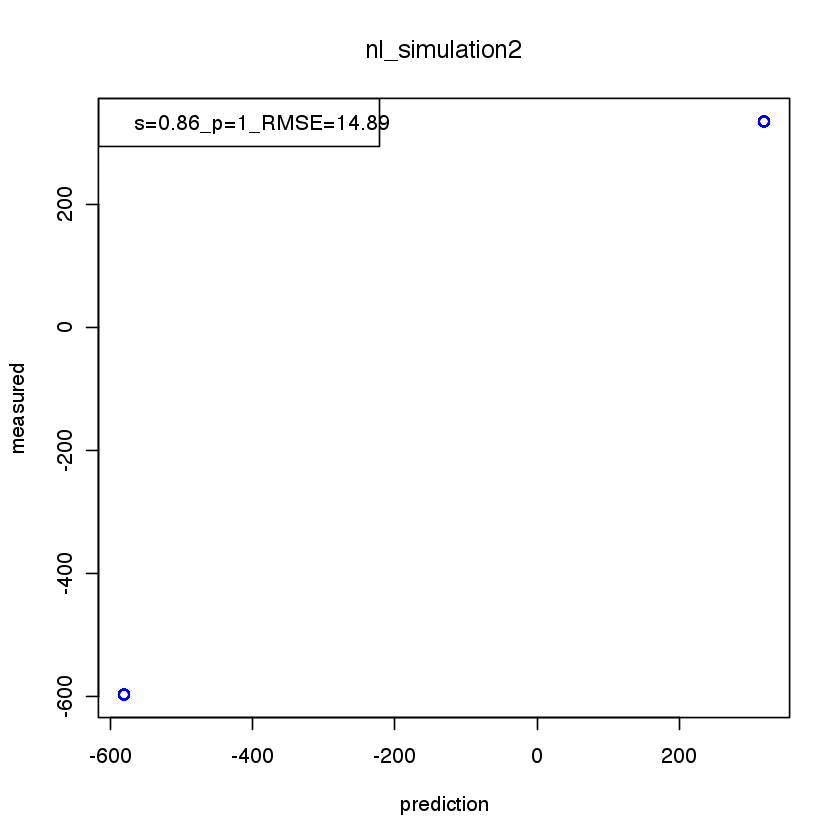

In [23]:
plot.scatter(partition$test$x,partition$test$y,cv.beta.mat.nl$best.nl,0,"measured",main=paste('nl',fileName,sep='_'),is_fl=F,intercept_mode,xlab='prediction')